# Machine Learning Pipeline 

This pipeline does the following:

1. Read / Load Data
2. Explore Data
3. Pre-Process and Clean Data
4. Generate Features / Predictors
5. Build Machine Learning Classifier 
6. Evaluate Classifier

## Read / Basic Clean / Explore 

In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

os.chdir('/Users/mariomoreno/Desktop/Grad School/Machine Learning/Week 2')

In [108]:
credit = pd.read_csv('credit-data.csv')

credit.rename(columns={"SeriousDlqin2yrs": "experienced_90days_delinquency", \
                    "NumberOfTime30-59DaysPastDueNotWorse": "times_30-59_pastdue", \
                    "DebtRatio": "debt_ratio", \
                    "MonthlyIncome": "monthly_income", \
                    "NumberOfOpenCreditLinesAndLoans": "times_open_credit_loans",\
                    "NumberOfTimes90DaysLate": "times_late", 
                    "NumberRealEstateLoansOrLines": "realestate_loans_lines", \
                    "NumberOfTime60-89DaysPastDueNotWorse": "times_60-89_pastdue",
                    "NumberOfDependents": "dependents",\
                    "RevolvingUtilizationOfUnsecuredLines": "use_unsecured_lines"
                    }, inplace = True)

In [109]:
nulls = credit.isnull().any()

credit['dependents'].fillna(0, inplace=True)
credit['monthly_income'].fillna(credit['monthly_income'].median(), inplace=True)      

Found the null values, which are in dependents and monthly_income. Since people who didn't report dependents are likely to not have any, filled them in with zeroes. Monthly income is different, imputed it as the mean of all the incomes. If I have time, I might explore K-Nearest Neighbor to take the monthly income of the neighbor most like our missing values.

In [110]:
credit.describe()

,PersonID,experienced_90days_delinquency,use_unsecured_lines,age,zipcode,times_30-59_pastdue,debt_ratio,monthly_income,times_open_credit_loans,times_late,realestate_loans_lines,times_60-89_pastdue,dependents
count,41016.000000,41016.000000,41016.00000,41016.000000,41016.000000,41016.000000,41016.000000,4.101600e+04,41016.000000,41016.000000,41016.000000,41016.000000,41016.000000
mean,115800.154598,0.161400,6.37587,51.683489,60623.824166,0.589233,331.458137,6.320623e+03,8.403477,0.419592,1.008801,0.371587,0.753681
std,28112.723511,0.367904,221.61895,14.746880,11.984357,5.205628,1296.109695,1.208056e+04,5.207324,5.190382,1.153826,5.169641,1.113639
min,22.000000,0.000000,0.00000,21.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106539.750000,0.000000,0.03431,41.000000,60618.000000,0.000000,0.176375,3.800000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,119901.500000,0.000000,0.18973,51.000000,60625.000000,0.000000,0.369736,5.250000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,134698.250000,0.000000,0.66716,62.000000,60629.000000,0.000000,0.866471,7.245500e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149999.000000,1.000000,22000.00000,109.000000,60644.000000,98.000000,106885.000000,1.794060e+06,56.000000,98.000000,32.000000,98.000000,13.000000


In [111]:
for i in credit:
    print()
    print(i, 'Summary Stats')
    print()
    print(credit[i].describe())



PersonID Summary Stats

count     41016.000000
mean     115800.154598
std       28112.723511
min          22.000000
25%      106539.750000
50%      119901.500000
75%      134698.250000
max      149999.000000
Name: PersonID, dtype: float64

experienced_90days_delinquency Summary Stats

count    41016.000000
mean         0.161400
std          0.367904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: experienced_90days_delinquency, dtype: float64

use_unsecured_lines Summary Stats

count    41016.00000
mean         6.37587
std        221.61895
min          0.00000
25%          0.03431
50%          0.18973
75%          0.66716
max      22000.00000
Name: use_unsecured_lines, dtype: float64

age Summary Stats

count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.000000
Name: age, dtype: float64

zipcode Summary

Might be worth dropping PersonID since it's random, might not have any impact on the final. A couple of points:

1) someone is 22,000 percent over their credit limit, which is ridiculous
2) someone's debt ratio is 106,885, which could be someone with no income
3) someone has more than 1 million in monthly income
4) someone has 32 real estate loans
5) someone has been 90 days late on payments 98 times

Unclear if these are outliers or not, but I do plan to bin on monthly income, which should minimize the effect of the millionaire. 

In [112]:
del credit['PersonID']

In [113]:
credit['experienced_90days_delinquency'].value_counts()

0    34396
1     6620
Name: experienced_90days_delinquency, dtype: int64

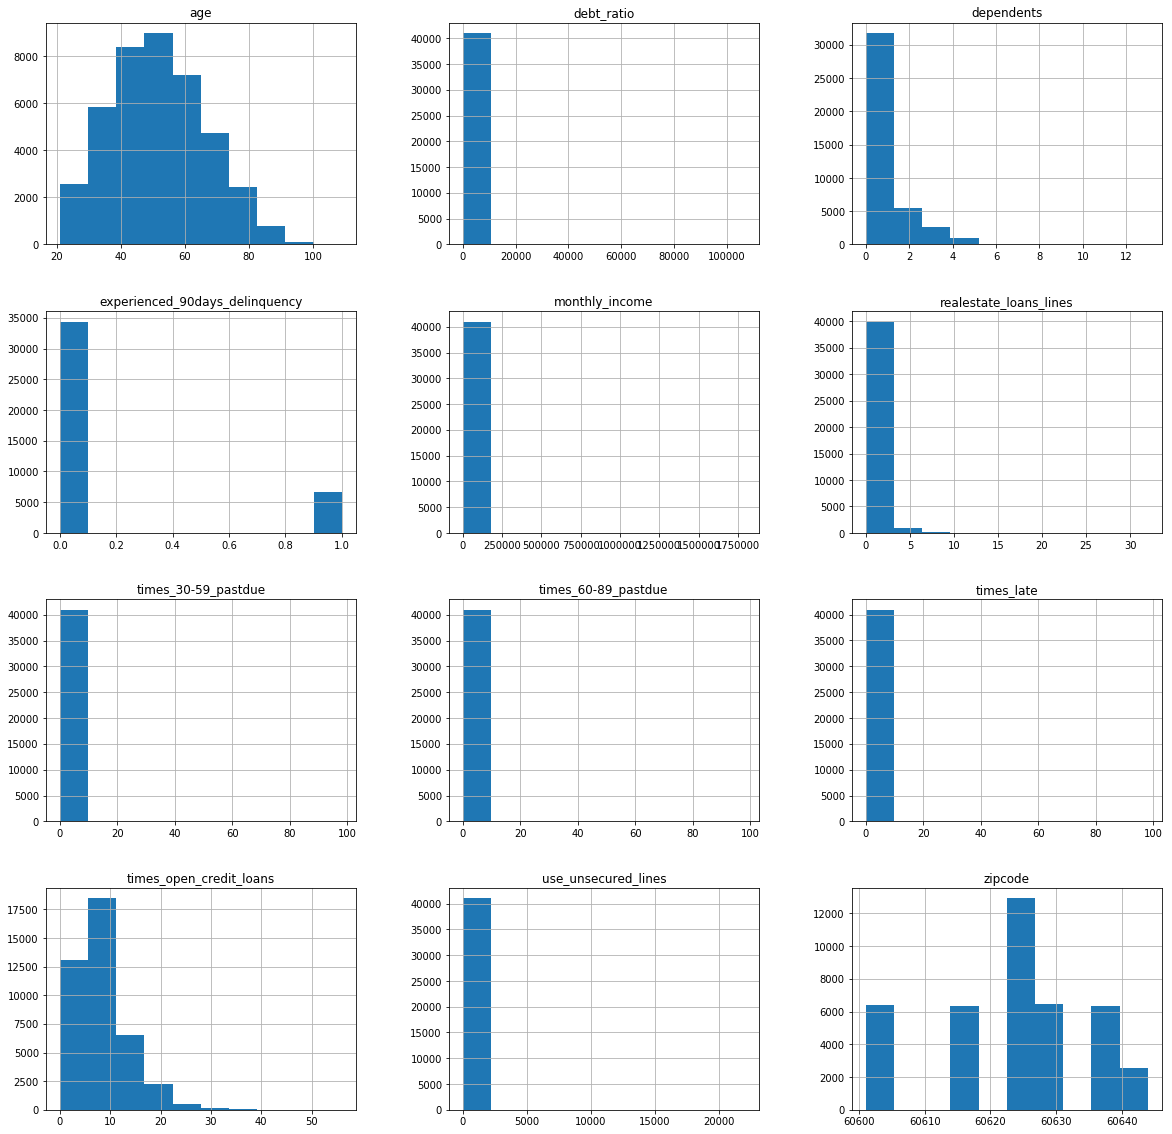

In [114]:
credit.hist(figsize=(20,20))
plt.show()

From these graphs, there's the potential for significant outliers in several different features. There might also be a need to discretize ages and monthly income.

In [115]:
correlations = []
    
for feature in credit:
    if feature != 'experienced_90days_delinquency':
        corr = credit['experienced_90days_delinquency'].astype('float64').corr(credit[feature].astype('float64'))
        correlations.append((feature, corr))

correlations

[('use_unsecured_lines', -0.0045861606035875165),
 ('age', -0.17372784435590619),
 ('zipcode', -0.045050979761833157),
 ('times_30-59_pastdue', 0.14933355423396405),
 ('debt_ratio', -0.013502206937829577),
 ('monthly_income', -0.028426002848322435),
 ('times_open_credit_loans', -0.039897662805912934),
 ('times_late', 0.13960916523540789),
 ('realestate_loans_lines', -0.010640862837506402),
 ('times_60-89_pastdue', 0.121886468335426),
 ('dependents', 0.066805785544506877)]

Taking a preliminary look at how correlated our independent variables might be with our dependent variable. Age is most significantly negatively correlated, while times 30-59 days past due is most significantly positively correlated. Neither variable is sufficiently correlated to suggest endogeneity.

In [116]:
for features in credit:
    print()
    print('Correlations for:', features)
    print()
    print(credit.corr().unstack()[features])
    print()


Correlations for: experienced_90days_delinquency

experienced_90days_delinquency    1.000000
use_unsecured_lines              -0.004586
age                              -0.173728
zipcode                          -0.045051
times_30-59_pastdue               0.149334
debt_ratio                       -0.013502
monthly_income                   -0.028426
times_open_credit_loans          -0.039898
times_late                        0.139609
realestate_loans_lines           -0.010641
times_60-89_pastdue               0.121886
dependents                        0.066806
dtype: float64


Correlations for: use_unsecured_lines

experienced_90days_delinquency   -0.004586
use_unsecured_lines               1.000000
age                              -0.008003
zipcode                           0.006009
times_30-59_pastdue              -0.001999
debt_ratio                        0.022250
monthly_income                    0.004875
times_open_credit_loans          -0.014590
times_late                       

There is significant correlation between three variables: times_late is 0.99 correlated with times_60-89_pastdue and .98 correlated with times_30-59_pastdue. 60-89 pastdue and 30-59 pastdue have similar correlation rates with each other. I'll drop those two to reduce noise.

In [117]:
del credit['times_30-59_pastdue']
del credit['times_60-89_pastdue']

## Graphing data

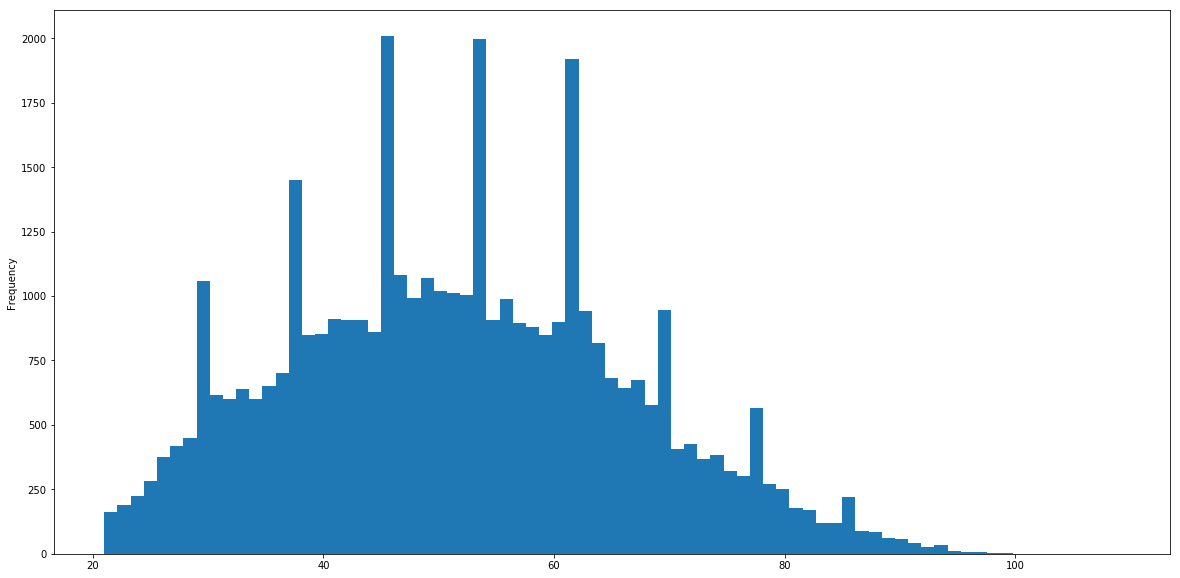

In [118]:
credit['age'].plot('hist', bins=77, figsize = (20, 10))
plt.show()

This distribution is a bit rocky, though it's important to note that there seems to be abnormal spikes in age at around each decade mark (30, 40, 50, etc...). I'll put a pin in that for future exploration. For now, I'll smooth out the distribution by discretizing.

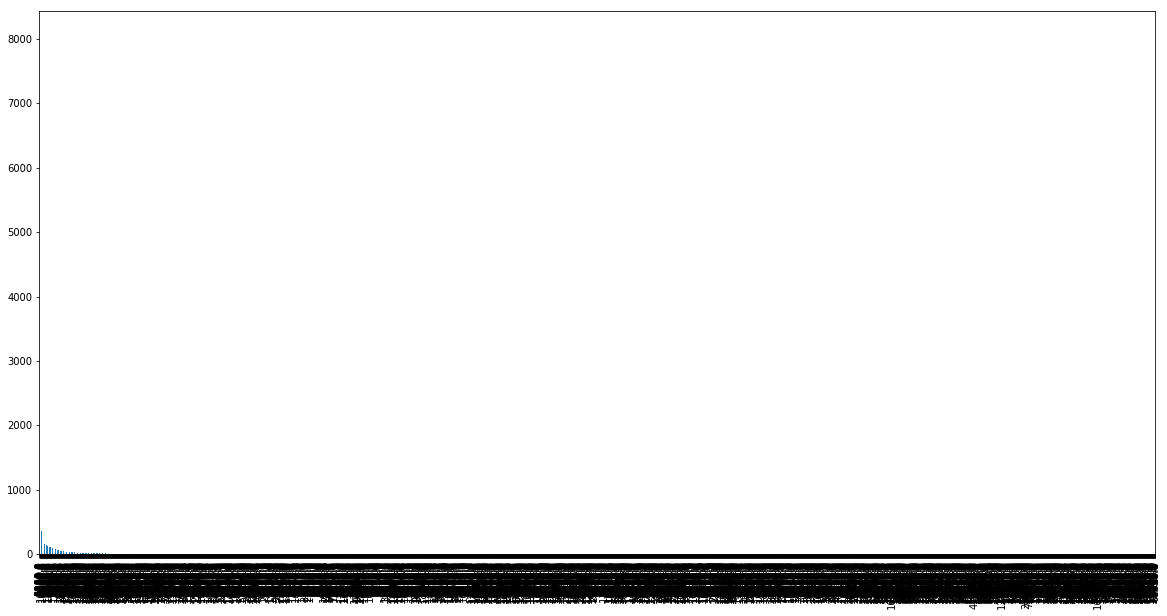

In [119]:
credit['monthly_income'].value_counts()[:10].plot(kind='bar', figsize = (20, 10))
plt.show()

Definitely something strange happening with monthly_income, there might be too many differing values to get an accurate sense. Will discretize.

In [120]:
age_bins = range(0, 110, 10)
income_bins = range(0, 200000, 10000)

credit['age_groups'] = pd.cut(credit['age'], age_bins, labels = False) 
credit['monthly_income_groups'] = pd.cut(credit['monthly_income'], income_bins, labels = False)


In [121]:
credit['times_late_binary'] = (credit['times_late'] >= credit['times_late'].mean()).astype(int)
del credit['times_late']

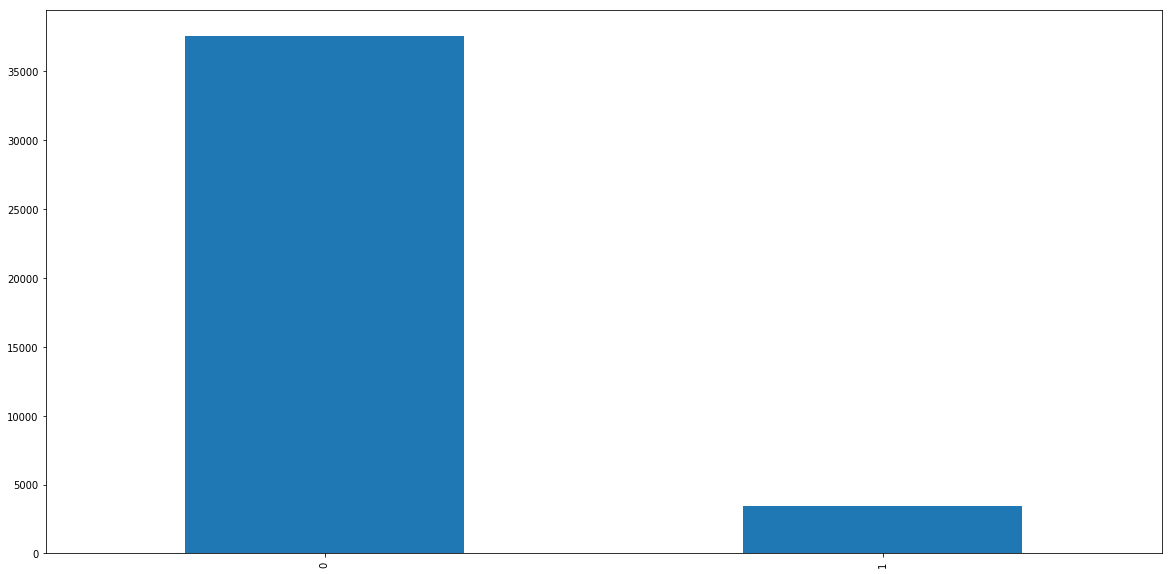

In [122]:
credit['times_late_binary'].value_counts().plot('bar', figsize=(20, 10))
plt.show()

In [123]:
credit['zipcode'].value_counts()

60625    12904
60629     6459
60601     6427
60637     6354
60618     6332
60644     2540
Name: zipcode, dtype: int64

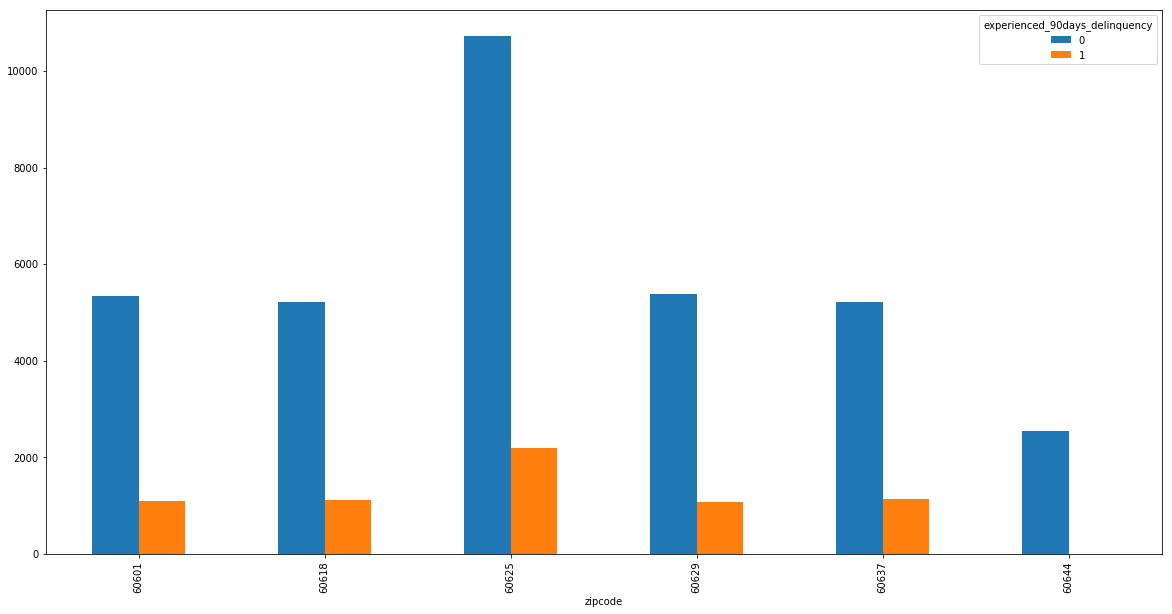

In [124]:
spms = credit[['experienced_90days_delinquency', 'zipcode']].groupby(['experienced_90days_delinquency', 'zipcode'])
spms.size().to_frame().reset_index()
to_graph = spms.size().to_frame().reset_index()
graph = to_graph.pivot_table(0, 'zipcode', 'experienced_90days_delinquency')
graph.plot.bar(figsize=(20, 10))
plt.show()

There's a significantly larger population for people both being delinqueny on their loans and not being delinquent on their loans at 60625. Since it's consistently larger across both, I'll take it as a function of just having a larger population and drop the variable. 

In [125]:
del credit['zipcode']

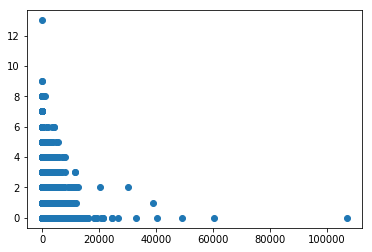

In [126]:
plt.scatter(credit['debt_ratio'], credit['dependents'])
plt.show()

Fascinatingly, the more kids you have, the lower your debt ratio.

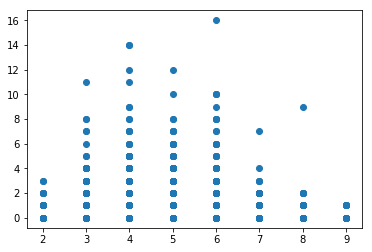

In [127]:
plt.scatter(credit['age_groups'], credit['monthly_income_groups'])
plt.show()

Not much to say here, other than the need to use the bins for both of these variables. I'll drop both age and monthly income shortly in favor of their bins

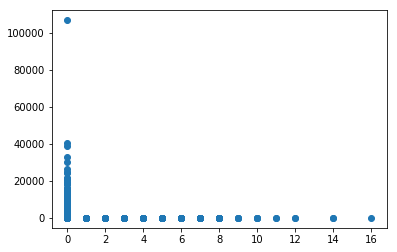

In [128]:
plt.scatter(credit['monthly_income_groups'], credit['debt_ratio'])
plt.show()

Pretty standard result here, the lower your income the higher your debt ratio.

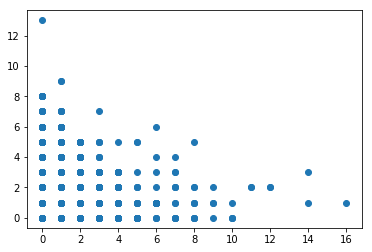

In [129]:
plt.scatter(credit['monthly_income_groups'], credit['dependents'])
plt.show()

Weird result in the sense that it contradicts previous results. The more kids you have, the lower your debt ratio according to an earlier graph. The lower your income, the higher your debt ration according to the previous graph. Yet, here, the lower your income, the more dependents you have. Putting a pin in this one, not sure how to interpret yet.

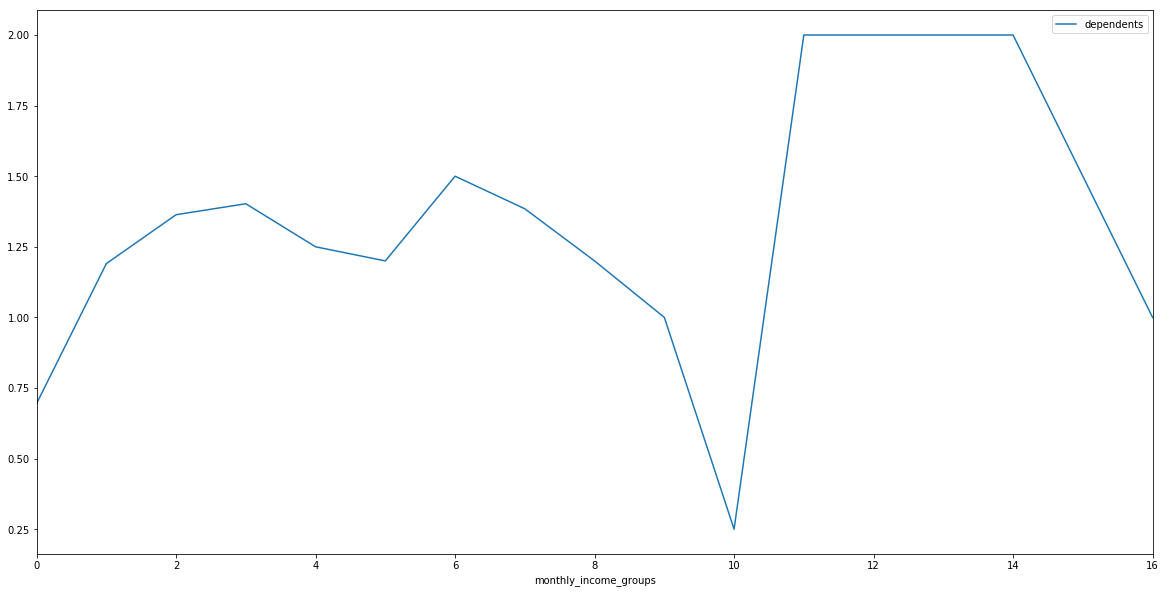

In [130]:
credit[['monthly_income_groups','dependents']].groupby('monthly_income_groups').mean().plot(figsize=(20,10))
plt.show()

With discretized values, we get a better sense of how dependents are distributed across the income groups. 

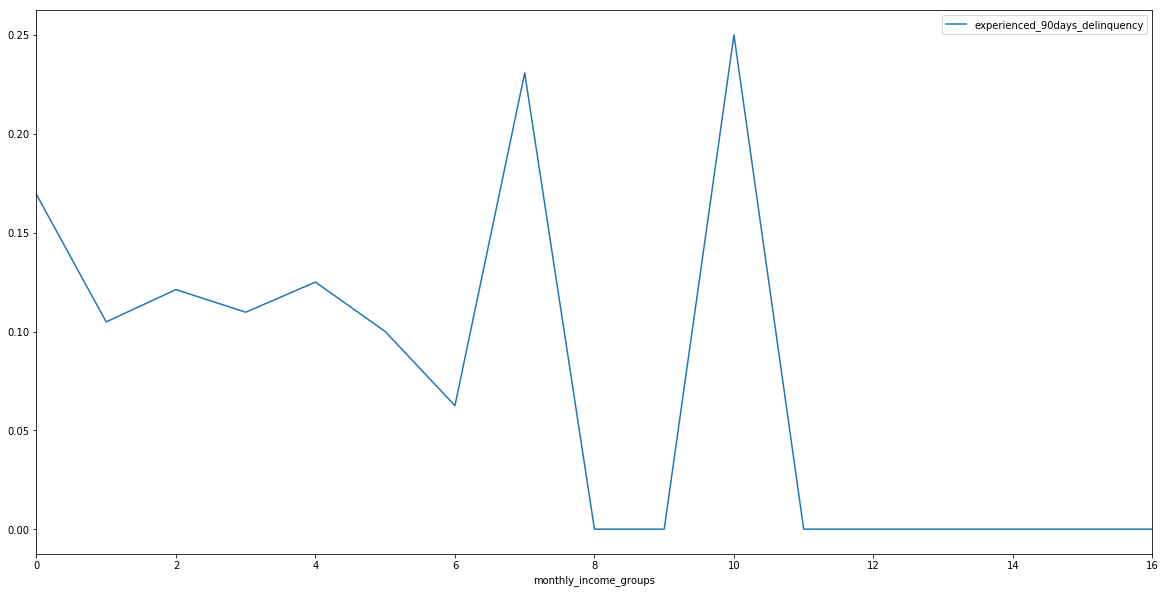

In [131]:
credit[['monthly_income_groups','experienced_90days_delinquency']].groupby('monthly_income_groups').mean().plot(figsize=(20,10))
plt.show()

Two significant spikes in delinquency at 70k and 100k, the first of which is likely due to imputation techinques

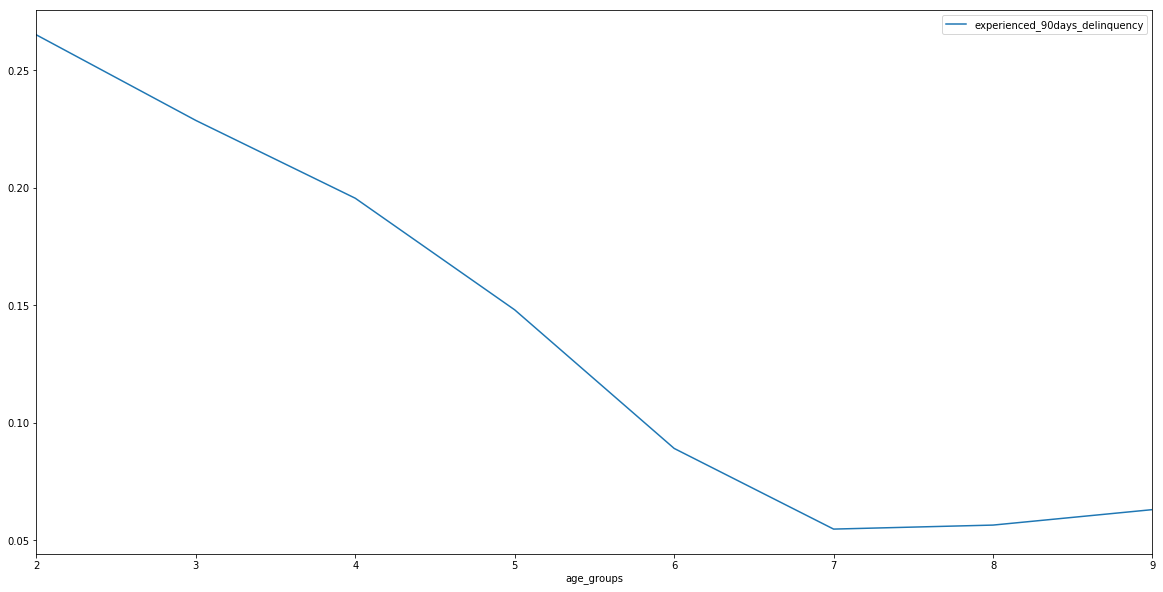

In [132]:
credit[['age_groups','experienced_90days_delinquency']].groupby('age_groups').mean().plot(figsize=(20,10))
plt.show()

Delinquency declines with age. 

After removing several variables due to multicollinearity, no potential explanatory power, or by nature of discretizing it, I've arrived at the features I'll be using.

In [133]:
del credit['age']
del credit['monthly_income']

## Split data

In [134]:
credit['experienced_90days_delinquency'] = credit['experienced_90days_delinquency'].astype('bool')
credit['experienced_90days_delinquency'].value_counts()

False    34396
True      6620
Name: experienced_90days_delinquency, dtype: int64

In [135]:
dependent = pd.DataFrame(credit['experienced_90days_delinquency'])
del credit['experienced_90days_delinquency']
credit['monthly_income_groups'].fillna(0, inplace=True)
credit['age_groups'].fillna(0, inplace=True)
test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(credit, dependent, test_size=test_size)

In [136]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(24609, 8)
(16407, 8)
(24609, 1)
(16407, 1)


Split training and test data, checked to make sure they were the right size

## K-Nearest Neighbor

In [138]:
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
weights = ['uniform', 'distance']
models = []

for k in range(10):
    for metric in metrics:
        for weight in weights:
            knn_loop = KNeighborsClassifier(n_neighbors=(k + 1), weights=weight, metric=metric)
            knn_loop.fit(x_train, y_train)
            results = knn_loop.predict(x_test)
            accuracy = accuracy_score(y_test, results, normalize = True, sample_weight = None)
            models.append({'Metric': metric, 'Weight': weight, 'Neighbors': (k+1), 'Accuracy': accuracy})
            
models_df = pd.DataFrame(models)
models_df
           
                    

/Users/mariomoreno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


,Accuracy,Metric,Neighbors,Weight
0,0.795148,euclidean,0,uniform
1,0.795148,euclidean,0,distance
2,0.797769,manhattan,0,uniform
3,0.797769,manhattan,0,distance
4,0.792832,chebyshev,0,uniform
5,0.792832,chebyshev,0,distance
6,0.795148,minkowski,0,uniform
7,0.795148,minkowski,0,distance
8,0.839824,euclidean,1,uniform
9,0.795697,euclidean,1,distance


In [141]:
x = models_df['Accuracy'].idxmax()

In [144]:
models_df.loc[x]

Accuracy       0.85043
Metric       manhattan
Neighbors            9
Weight         uniform
Name: 74, dtype: object